## This is the faster way to access the data remotely using NetCDF files

This method is significantly faster than loading the data into local memory. It depends on the thredds server running on 128.112.335.246. This example is for calculating accumulated rain for one day.

In [109]:
import xarray as xr
from rain import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [110]:
remote_data = xr.open_dataset('http://128.112.35.246/thredds/dodsC/UrbanRainfall/Phoenix.nc', decode_times=True)

In [111]:
f = remote_data.sel(time='2014-08-19').sum('time')

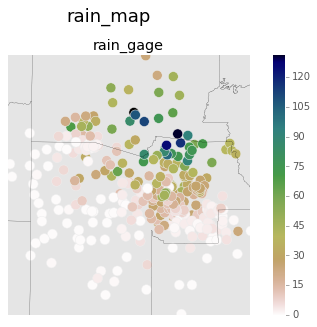

In [112]:
Event(f.to_dataframe()).map_rain(basemap=True)